In [1]:
import numpy as np 
import pandas as pd
import os

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string

df=pd.read_csv('input/deceptive-opinion.csv')


In [2]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."


**Exploratory analysis**

The column "deceptive" is the Outcome column (y)
The column "text" is the main input column (X).

Other columns polarity, source, hotel can be ignored for ML analysis.

<AxesSubplot:xlabel='deceptive', ylabel='count'>

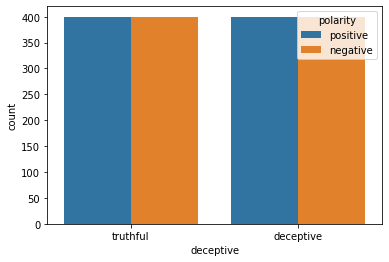

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

**Additional Analysis**

Based on the above graphs, It shows that data is well distributed. There is equal amount of data which has been identified as truthful and deceptive. Data is evenly distributed with polarity as well.

Below graph shows that there is almost equal amount of data distributed across all hotels.

<AxesSubplot:xlabel='deceptive', ylabel='count'>

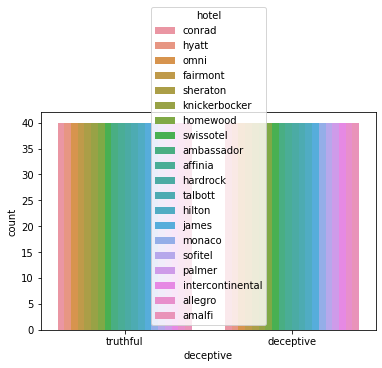

In [4]:
sns.countplot(x=df['deceptive'],hue='hotel',data=df)

**Utility function**

Definig a utility function to preprocess data for further steps like tokenization.

In [5]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


def text_cleaning(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in (stop)])
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text) # Remove Unicode chars
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kapilchopra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['text']=df['text'].apply(text_cleaning)   #Apply the function to clean up data.

In [7]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,stayed one night getaway family thursday tripl...
1,truthful,hyatt,positive,TripAdvisor,triple rate upgrade view room less also inclu...
2,truthful,hyatt,positive,TripAdvisor,comes little late im finally catching reviews ...
3,truthful,omni,positive,TripAdvisor,omni chicago really delivers fronts spaciousne...
4,truthful,hyatt,positive,TripAdvisor,asked high floor away elevator got room pleasa...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,problems started booked intercontinental chica...
1596,deceptive,amalfi,negative,MTurk,amalfi hotel beautiful website interior decora...
1597,deceptive,intercontinental,negative,MTurk,intercontinental chicago magnificent mile outs...
1598,deceptive,palmer,negative,MTurk,palmer house hilton looks good pictures outsid...


In [8]:
df['complete_text']=df['text']

In [9]:
x=df['complete_text']
y=df['deceptive']

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)

In [11]:
y

array([1, 1, 1, ..., 0, 0, 0])

**Split data into random train and test subsets**

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

**Vectorization - Convert a collection of text documents to a matrix of token counts**

Experimented with various ngram_range and (1,2) seems to be giving best results.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,2))

In [14]:
x_train=cv.fit_transform(x_train)

In [15]:
x_train

<1280x76330 sparse matrix of type '<class 'numpy.int64'>'
	with 173735 stored elements in Compressed Sparse Row format>

**Apply LogisticRegression**

In [16]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=100000)
lr.fit(x_train,y_train)
pred_1=lr.predict(cv.transform(x_test))

In [17]:
from sklearn.metrics import accuracy_score
score_1=accuracy_score(y_test,pred_1)

In [18]:
score_1

0.8625

In [22]:
%%time

from sklearn.model_selection   import GridSearchCV
import warnings
warnings.filterwarnings( 'ignore' )

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)   
clf.fit(x_train,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.865625
CPU times: user 4min 19s, sys: 1min 7s, total: 5min 26s
Wall time: 42.9 s


**Apply SVM**

In [19]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(x_train,y_train)
pred_2=svm.predict(cv.transform(x_test))
score_2=accuracy_score(y_test,pred_2)

In [20]:
score_2

0.85625

**Apply Naive Bayes**

In [21]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(x_train,y_train)
pred_3=nb.predict(cv.transform(x_test))
score_3=accuracy_score(y_test,pred_3)

In [22]:
score_3

0.88125